In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("mrk_project_csv.csv")

## Remove 0,6 in the overall ratings
df['Q7ALL'] = df['Q7ALL'].replace(['BLANK','6','0'],7)
df['Q7ALL_new'] = df['Q7ALL'].dropna().astype('int64', inplace=True)

#### Clustering

In [2]:
df_q7 = df[list(df.columns[35:50])].dropna()
X_q7 = df_q7.iloc[:,:-1]

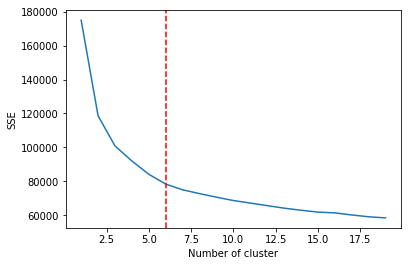

In [3]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

sse = {}

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_q7.index.values

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k,random_state=50).fit(X_q7)
    cluster_map['cluster'] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.axvline(x=6, c='r', linestyle='--')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [4]:
clus_num = 6
kmeans = KMeans(clus_num,random_state=50).fit(X_q7)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_q7.index.values
cluster_map['cluster'] = kmeans.labels_
X_reset = X_q7.reset_index().drop(columns='index')
for i in range(clus_num):
    print(X_reset[cluster_map['cluster']==i].shape)

(1185, 14)
(242, 14)
(1718, 14)
(162, 14)
(1029, 14)
(1304, 14)


In [5]:
from sklearn.linear_model import LinearRegression
from scipy import stats

for i in range(clus_num):
    
    X = X_reset[cluster_map['cluster']==i].reset_index().drop(columns='index')
    y = df_q7['Q7ALL'].reset_index().drop(columns='index').astype('float64')[cluster_map['cluster']==i]['Q7ALL']

    lm = LinearRegression().fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    #sd_b = np.round(sd_b,3)
    #ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    #params = np.round(params,4)

    result = pd.DataFrame()
    result["Coefficients"],result["Standard Errors"],result["t values"],result["Probabilites"] = [params,sd_b,ts_b,p_values]
    l = list(X.columns)
    l.insert(0,'intercept')
    result['Name'] = l
    col = ['Name', 'Coefficients', 'Standard Errors', 't values', 'Probabilites']
    result = result[col]
    print('Cluster: ',i+1,'\n',result,'\n\n')

('Cluster: ', 1.6597384301820897, '\n',            Name  Coefficients  Standard Errors  t values  Probabilites
0     intercept      2.929835         0.406243  7.212023         0.000
1         Q7ART     -0.007147         0.019188 -0.372481         0.710
2        Q7FOOD      0.066970         0.023507  2.848932         0.004
3       Q7STORE      0.078863         0.024359  3.237534         0.001
4        Q7SIGN      0.107379         0.030362  3.536609         0.000
5     Q7WALKWAY      0.083387         0.032075  2.599707         0.009
6     Q7SCREENS      0.143350         0.030546  4.692846         0.000
7    Q7INFODOWN      0.032135         0.024800  1.295776         0.195
8      Q7INFOUP      0.006094         0.024381  0.249946         0.803
9        Q7WIFI      0.018872         0.018248  1.034224         0.301
10      Q7ROADS      0.022127         0.021212  1.043126         0.297
11       Q7PARK     -0.018506         0.025838 -0.716232         0.474
12   Q7AIRTRAIN     -0.025416        

#### PCA regression

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = X_reset.reset_index().drop(columns='index')
y = df_q7['Q7ALL'].reset_index().drop(columns='index').astype('float64')

stdScaler = StandardScaler()
X_scaled = stdScaler.fit_transform(X)

pca = PCA(n_components = 3)
pca_result = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2', 'PC3'])
print(pd.DataFrame(pca.components_,columns=X.columns,index = ['PC1','PC2','PC3']))

        Q7ART    Q7FOOD   Q7STORE    Q7SIGN  Q7WALKWAY  Q7SCREENS  Q7INFODOWN  \
PC1 -0.230746 -0.229860 -0.241125 -0.248286  -0.266436  -0.266854   -0.287512   
PC2  0.203776  0.263105  0.260874  0.282864   0.256012   0.270360    0.116451   
PC3  0.179039  0.352518  0.287159  0.141471   0.121799   0.026986   -0.561588   

     Q7INFOUP    Q7WIFI   Q7ROADS    Q7PARK  Q7AIRTRAIN  Q7LTPARKING  Q7RENTAL  
PC1 -0.283746 -0.245896 -0.277137 -0.290853   -0.290272    -0.287377 -0.282932  
PC2  0.128694  0.106901 -0.287737 -0.346221   -0.319150    -0.368322 -0.347587  
PC3 -0.572150 -0.207352  0.157898  0.055265    0.082726     0.017567  0.069060  


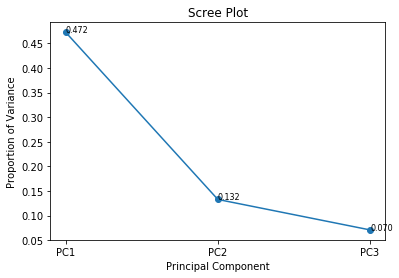

In [7]:
pca_list = ['PC1', 'PC2', 'PC3']
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance')
plt.plot(pca_list, pca.explained_variance_ratio_, marker='o')
for a,b in zip(pca_list, pca.explained_variance_ratio_): 
    plt.text(a, b, str(b)[0:5], fontsize=8)
plt.show()

In [8]:
for i in range(clus_num):
    
    X_pca_clust = X_pca[cluster_map['cluster']==i].reset_index().drop(columns='index')
    y_pca = y[cluster_map['cluster']==i].reset_index().drop(columns='index')['Q7ALL']
        
    lm = LinearRegression().fit(X_pca_clust,y_pca)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X_pca_clust)

    newX = pd.DataFrame({"Constant":np.ones(len(X_pca_clust))}).join(pd.DataFrame(X_pca_clust))
    MSE = (sum((y_pca-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    #sd_b = np.round(sd_b,3)
    #ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    #params = np.round(params,4)

    result = pd.DataFrame()
    result["Coefficients"],result["Standard Errors"],result["t values"],result["Probabilites"] = [params,sd_b,ts_b,p_values]
    l = ['PC1','PC2','PC3']
    l.insert(0,'intercept')
    result['Name'] = l
    col = ['Name', 'Coefficients', 'Standard Errors', 't values', 'Probabilites']
    result = result[col]
    print('Cluster: ',i+1,'\n',result,'\n')

('Cluster: ', 2.4540972046125145, '\n',         Name  Coefficients  Standard Errors   t values  Probabilites
0  intercept      4.172375         0.045744  91.211380         0.000
1        PC1     -0.147260         0.028750  -5.122136         0.000
2        PC2      0.188821         0.028935   6.525818         0.000
3        PC3      0.041296         0.028400   1.454097         0.146, '\n')
('Cluster: ', 2.7344019681634233, '\n',         Name  Coefficients  Standard Errors  t values  Probabilites
0  intercept      3.327827         0.486115  6.845765         0.000
1        PC1      0.026629         0.071749  0.371138         0.711
2        PC2      0.294910         0.071714  4.112310         0.000
3        PC3      0.104471         0.060235  1.734402         0.084, '\n')
('Cluster: ', 4.824210031765585, '\n',         Name  Coefficients  Standard Errors   t values  Probabilites
0  intercept      4.107190         0.059715  68.779931           0.0
1        PC1     -0.154548         0.025779 

#### Correlation

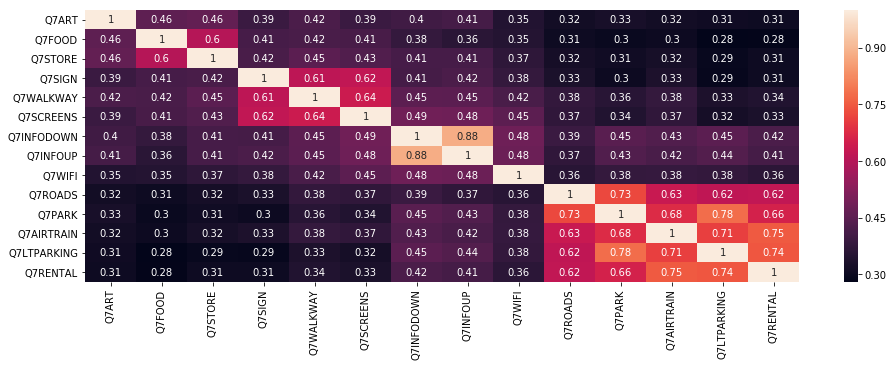

In [9]:
import seaborn as sns
corr = X_q7.corr()
plt.figure(figsize = (16,5))
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot = True)

In [10]:
X_all = df[list(df.columns[35:49])]
X_binned = pd.DataFrame()

X_binned['Art'] = X_all['Q7ART']
X_binned['Food&Store'] = X_all[['Q7FOOD','Q7STORE']].mean(axis=1)
X_binned['Direction'] = X_all[['Q7SIGN','Q7WALKWAY','Q7SCREENS']].mean(axis=1)
X_binned['InfoBooth'] = X_all[['Q7INFODOWN','Q7INFOUP']].mean(axis=1)
X_binned['Transportation'] = X_all[['Q7ROADS','Q7PARK','Q7AIRTRAIN','Q7LTPARKING','Q7RENTAL']].mean(axis=1)
X_binned['Wifi'] = X_all['Q7WIFI']

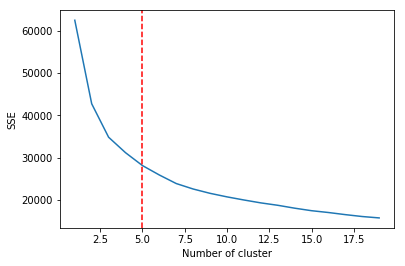

In [11]:
sse_binned = {}

cluster_map_binned = pd.DataFrame()
cluster_map_binned['data_index'] = X_binned.index.values

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k,random_state=50).fit(X_binned)
    cluster_map_binned['cluster'] = kmeans.labels_
    #print(data["clusters"])
    sse_binned[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_binned.keys()), list(sse_binned.values()))
plt.axvline(x=5, c='r', linestyle='--')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [12]:
clus_num = 5
kmeans = KMeans(clus_num, random_state=91).fit(X_binned)
cluster_map_binned = pd.DataFrame()
cluster_map_binned['data_index'] = X_binned.index.values
cluster_map_binned['cluster'] = kmeans.labels_
X_reset_binned = X_binned.reset_index().drop(columns='index')
for i in range(clus_num):
    print(X_reset_binned[cluster_map_binned['cluster']==i].shape)

(2016, 6)
(1540, 6)
(160, 6)
(734, 6)
(1190, 6)


In [13]:
for i in range(clus_num):
    
    X_binned_clust = X_reset_binned[cluster_map_binned['cluster']==i].reset_index().drop(columns='index')
    y = df_q7['Q7ALL'].reset_index().drop(columns='index').astype('float64')[cluster_map_binned['cluster']==i]['Q7ALL']

    lm = LinearRegression(fit_intercept=False).fit(X_binned_clust,y)
    params = lm.coef_
    predictions = lm.predict(X_binned_clust)

    #newX = pd.DataFrame({"Constant":np.ones(len(X_binned_clust))}).join(pd.DataFrame(X_binned_clust))
    MSE = (sum((y-predictions)**2))/(len(X_binned_clust)-len(X_binned_clust.columns))

    var_b = MSE*(np.linalg.inv(np.dot(X_binned_clust.T,X_binned_clust)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(j),(len(X_binned_clust)-1))) for j in ts_b]

    #sd_b = np.round(sd_b,3)
    #ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    #params = np.round(params,4)

    result = pd.DataFrame()
    result["Coefficients"],result["Standard Errors"],result["t values"],result["Probabilites"] = [params,sd_b,ts_b,p_values]
    l = list(X_binned.columns)
    result['Name'] = l
    col = ['Name', 'Coefficients', 'Standard Errors', 't values', 'Probabilites']
    result = result[col]
    print'Cluster: ',i+1,'\n',result,'\n\n'

Cluster:  1 
             Name  Coefficients  Standard Errors   t values  Probabilites
0             Art      0.037064         0.020499   1.808098         0.071
1      Food&Store      0.162442         0.019453   8.350465         0.000
2       Direction      0.571718         0.025152  22.730438         0.000
3       InfoBooth      0.021603         0.023404   0.923026         0.356
4  Transportation      0.045865         0.025250   1.816488         0.069
5            Wifi      0.106358         0.020668   5.146034         0.000 


Cluster:  2 
             Name  Coefficients  Standard Errors   t values  Probabilites
0             Art      0.070767         0.017318   4.086297           0.0
1      Food&Store      0.194932         0.023187   8.406861           0.0
2       Direction      0.400922         0.029481  13.599490           0.0
3       InfoBooth      0.143714         0.024406   5.888527           0.0
4  Transportation      0.123644         0.018481   6.690380           0.0
5        

In [14]:
df['purp_added'] = df['Q2PURP1']
def combine_purp(x):
    if x == 6:
        return 3
    elif x == 5:
        return 4
    elif x in (10,11,12,13,0):
        return 7
    else:
        return x
df['purp_added'] = df['purp_added'].map(combine_purp)

In [15]:
for i in range(clus_num): 
    print("Cluster: ", i+1,)
    print(df['purp_added'][cluster_map_binned['cluster']==i].value_counts()/df['purp_added'].value_counts()).sort_values(ascending=False), '\n\n'

('Cluster: ', 1)
7    0.500000
4    0.413043
3    0.381290
2    0.365927
1    0.298736
Name: purp_added, dtype: float64 


('Cluster: ', 2)
1    0.288090
2    0.283945
4    0.252174
3    0.250177
7    0.201299
Name: purp_added, dtype: float64 


('Cluster: ', 3)
7    0.051948
3    0.034727
2    0.027754
1    0.024617
4    0.004348
Name: purp_added, dtype: float64 


('Cluster: ', 4)
7    0.142857
3    0.138200
1    0.137059
2    0.122118
4    0.108696
Name: purp_added, dtype: float64 


('Cluster: ', 5)
1    0.251497
4    0.221739
2    0.200256
3    0.195606
7    0.103896
Name: purp_added, dtype: float64 




In [16]:
df['Q22Income'].value_counts()

4    1340
2    1317
0    1174
3     937
1     850
5      22
Name: Q22Income, dtype: int64

In [17]:
for i in range(clus_num): 
    print "Cluster: ", i+1
    print (df['Q22Income'][cluster_map_binned['cluster']==i].value_counts()/df['Q22Income'].value_counts()).sort_values(ascending=False),'\n\n'

Cluster:  1
1    0.424706
2    0.388762
0    0.368825
3    0.336179
4    0.292537
5    0.136364
Name: Q22Income, dtype: float64 


Cluster:  2
5    0.500000
3    0.297759
4    0.282836
2    0.274867
1    0.263529
0    0.242760
Name: Q22Income, dtype: float64 


Cluster:  3
0    0.060477
1    0.023529
4    0.021642
2    0.019742
3    0.014941
5         NaN
Name: Q22Income, dtype: float64 


Cluster:  4
5    0.227273
3    0.144077
0    0.137138
4    0.133582
2    0.121488
1    0.110588
Name: Q22Income, dtype: float64 


Cluster:  5
4    0.269403
3    0.207044
2    0.195140
0    0.190801
1    0.177647
5    0.136364
Name: Q22Income, dtype: float64 




In [19]:
q8 = df[['Q8-1', 'Q8-2', 'Q8-3', 'Q8-4', 'Q8-5']][cluster_map_binned['cluster']==0]

q8 = q8.loc[(df['Q8-1']!=0)]
#print q8['Q8-5'].dtype
#q8 = q8['index'].astype(int)
q8 = q8[q8['Q8-5'] != '503?']
#print size(q8)
q8 = q8.apply(lambda x: x.astype(float))
#q8
#print q8.apply(pd.Series.value_counts)
q8 = q8.apply(pd.Series.value_counts)
q8['sum'] = q8.sum(axis=1)

q8 = q8.reset_index()
q8['index'] = q8['index'].astype(int)

amenities = q8[(q8['index'].between(11,27, inclusive = True))==True]
boarding = q8[(q8['index'].between(31,36, inclusive = True))==True]
sign = q8[(q8['index'].between(51,67, inclusive = True))==True]
getting_to_airport  = q8[(q8['index'].between(71,78, inclusive = True))==True]
restaurants = q8[(q8['index'].between(101,110, inclusive = True))==True]
shops = q8[(q8['index'].between(151,155, inclusive = True))==True]
security = q8[(q8['index'].between(201,212, inclusive = True))==True]
airlines = q8[(q8['index'].between(501,510, inclusive = True))==True]
airline_specific = q8[(q8['index'].between(801,806, inclusive = True))==True]
positive = q8[(q8['index'].between(991,999, inclusive = True))==True]


#1: General positive comment/keep up the good work/everything is great/can’t think of anythng else'
#102: Offer a wider variety/selection of restaurants/add more restaurants (overall)
#14: Charging stations/plugs don’t work/add more plugs/easier to find outlets/work stations
#11: Better Wi-Fi/could not connect/other Wi-Fi issues/SFO website or mobile app issues
#101: Too expensive/reduce prices/offer cheaper options/offer free coffee/food

In [22]:
#Cluster 1: 102- 
restaurants[['index','sum']].sort_values(by  = 'sum', ascending = False)


,index,sum
62,102,66.0
61,101,41.0
63,103,34.0
64,104,16.0
65,105,15.0
67,107,7.0
69,109,6.0
66,106,5.0
70,110,4.0
68,108,1.0


In [27]:
q15 = df[['Q15-1','Q15-2','Q15-3']][cluster_map_binned['cluster']==1]
q15 = q15.loc[(df['Q15-1']!=0)]
#print q8['Q8-5'].dtype
#q8 = q8['index'].astype(int)
#q15 = q15[q15['Q8-5'] != '503?']
#print size(q8)
q15 = q15.apply(lambda x: x.astype(float))
#q8
#print q8.apply(pd.Series.value_counts)
q15 = q15.apply(pd.Series.value_counts)
q15['sum'] = q15.sum(axis=1)

q15 = q15.reset_index()
q15['index'] = q15['index'].astype(int)

q15[['index','sum']].sort_values(by='sum',ascending= False)
#32- Security took too long/too confusing/staff rude
#5- Difficulty finding gate/terminal
#1 - Signs/info boards provided confusing/incomplete information
#53 - Excessive flight delay/cancellation
#44 - Airline check-in was confusing/crowded/understaffed/took too long/not open


,index,sum
20,32,48.0
4,5,21.0
0,1,20.0
33,53,18.0
27,44,12.0
31,51,11.0
19,31,9.0
1,2,7.0
32,52,7.0
10,13,6.0


In [29]:
q15 = df[['Q15-1','Q15-2','Q15-3']]
q15 = q15.loc[(df['Q15-1']!=0)]
#print q8['Q8-5'].dtype
#q8 = q8['index'].astype(int)
#q15 = q15[q15['Q8-5'] != '503?']
#print size(q8)
q15 = q15.apply(lambda x: x.astype(float))
#q8
#print q8.apply(pd.Series.value_counts)
q15 = q15.apply(pd.Series.value_counts)
q15['sum'] = q15.sum(axis=1)

q15 = q15.reset_index()
q15['index'] = q15['index'].astype(int)

q15[['index','sum']].sort_values(by='sum',ascending= False)
#32
#53
#1
#44
#5

,index,sum
22,32,151.0
0,1,73.0
4,5,70.0
36,53,52.0
30,44,44.0
34,51,30.0
21,31,29.0
11,13,23.0
31,45,20.0
16,23,18.0
